# Loan repayment

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys

from sklearn.preprocessing import  StandardScaler # LabelEncoder, RobustScaler, MinMaxScaler,

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression, LinearRegression,  SGDRegressor, Ridge, RidgeCV
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier
 
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split #cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, LeaveOneOut, cross_validate

# from sklearn.ensemble import RandomForestRegressor, StackingRegressor
# from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error #auc,
# #from sklearn import metrics

# from sklearn.feature_selection import SelectKBest, f_regression

import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

!pip freeze > requirements.txt

In [25]:
from utils.config_reader import config_reader

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [ ]:
# df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
# df

# sample = df.sample(n=100000 , axis=0, random_state=random_seed)
# display(sample)
# sample.to_csv('../data/sample.csv') 

,id,member_id,loan_amnt,funded_amnt,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,...,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,...,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,...,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2260697,88224441,NaN,24000.0,24000.0,...,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,...,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2260700,Total amount funded in policy code 2: 521953170,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN


<AxesSubplot: xlabel='Count', ylabel='loan_status'>

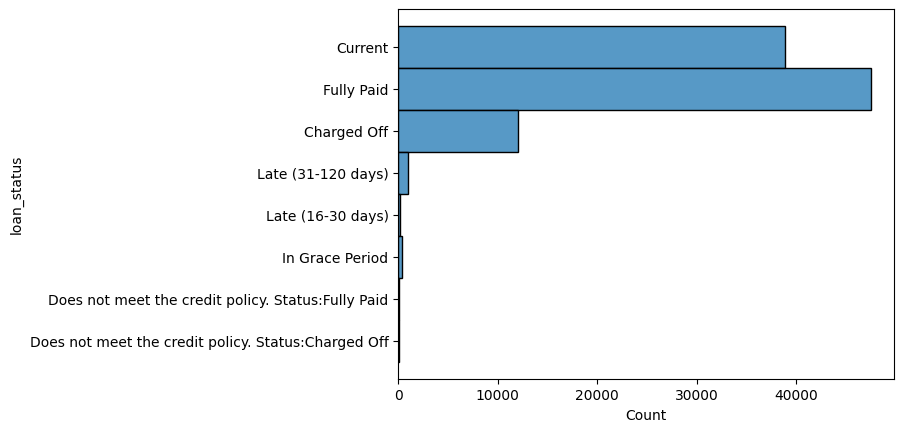

In [26]:
df = pd.read_csv('../data/sample.csv')
sns.histplot(df, y='loan_status')

<AxesSubplot: xlabel='loan_amnt'>

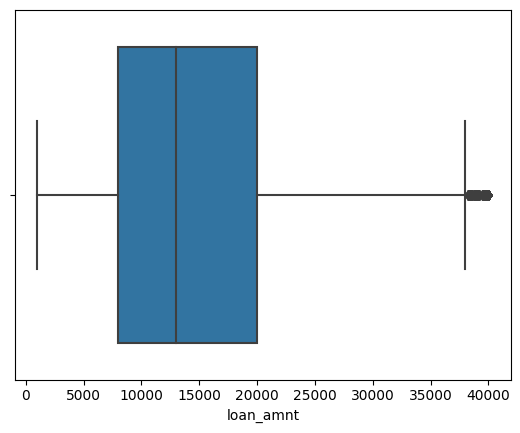

In [27]:
sns.boxplot(df, x='loan_amnt')

<AxesSubplot: xlabel='Count', ylabel='loan_status'>

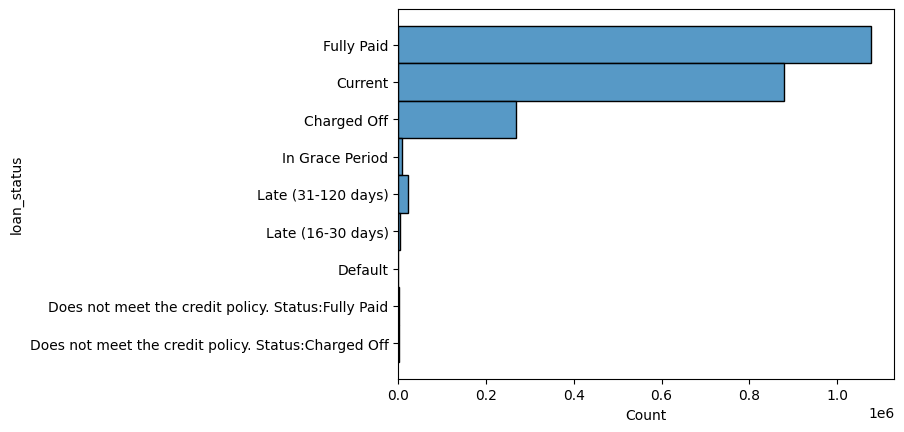

In [ ]:
sns.histplot(df, y='loan_status')


,id,member_id,loan_amnt,funded_amnt,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
392949,39651438,NaN,32000.0,32000.0,...,NaN,NaN,NaN,NaN
1273506,16411620,NaN,9600.0,9600.0,...,NaN,NaN,NaN,NaN
324024,45122316,NaN,4000.0,4000.0,...,NaN,NaN,NaN,NaN
2066630,125356772,NaN,6025.0,6025.0,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
363389,41368988,NaN,25200.0,25200.0,...,NaN,NaN,NaN,NaN
1908460,1513211,NaN,10000.0,10000.0,...,NaN,NaN,NaN,NaN
1487889,135125990,NaN,20000.0,20000.0,...,NaN,NaN,NaN,NaN
347653,43165428,NaN,12000.0,12000.0,...,NaN,NaN,NaN,NaN


In [ ]:
columns_list = df.columns.to_list()
columns_list

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '